## North Yorkshire Cycling:
### Identifying the Best Town for a New Bike Shop

###### Scraping Population Data for North Yorkshire Towns from Wikipedia

In [196]:
import warnings
warnings.filterwarnings("ignore")

# import urllib library
import urllib.request

# url for Wikipedia page
url = "https://en.wikipedia.org/wiki/North_Yorkshire"

# open the url using the imported urllib.request and assign HTML to a variable
page = urllib.request.urlopen(url)

# import BeautifulSoup library. Needed to parse HTML and XML documents
from bs4 import BeautifulSoup

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "lxml")
# lxml is a Python library which allows for easy handling of XML and HTML files

In [197]:
# Correct table in Wikipedia page
right_table = soup.find('table', class_='wikitable sortable')

In [198]:
Town=[]
Population=[]

for row in right_table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells) == 6:
        Town.append(cells[1].find(text=True))
        Population.append(cells[2].find(text=True))

In [199]:
import pandas as pd
dict = {"Town":Town,"Population":Population}
df = pd.DataFrame(dict)
df.head()

,Town,Population
0,Middlesbrough,"174,700"
1,York,"152,841"
2,Harrogate,"73,576"
3,Scarborough,"38,715 (approximate)"
4,Redcar,"37,073"


In [200]:
# Clean Population Column
df.iloc[3,1] = df.iloc[3,1][0:-14]
df.head()

,Town,Population
0,Middlesbrough,"174,700"
1,York,"152,841"
2,Harrogate,"73,576"
3,Scarborough,"38,715"
4,Redcar,"37,073"


In [201]:
# Remove commas and convert to int
for i in range(0,20):
    df.iloc[i,1] = int(df.iloc[i,1].replace(',',''))
df.head()

,Town,Population
0,Middlesbrough,174700
1,York,152841
2,Harrogate,73576
3,Scarborough,38715
4,Redcar,37073


In [203]:
# Use geocoder API to acquire Latitude and Longitude for towns

key = "************************************"

from opencage.geocoder import OpenCageGeocode
geocoder = OpenCageGeocode(key)
Latitude = []
Longitude = []

for i in range(0,20):
    query = (str(df.iloc[i,0])+", Yorkshire")
    results = geocoder.geocode(query)
    lat = results[0]['geometry']['lat']
    lng = results[0]['geometry']['lng']
    Latitude.append(lat)
    Longitude.append(lng)
    #print (str(df.iloc[i,0]), lat, lng)

df["Latitude"] = Latitude
df["Longitude"] = Longitude
df

,Town,Population,Latitude,Longitude
0,Middlesbrough,174700,54.580179,-1.176194
1,York,152841,53.959055,-1.081536
2,Harrogate,73576,53.992149,-1.539104
3,Scarborough,38715,54.282001,-0.401187
4,Redcar,37073,53.507424,-0.493462
5,Thornaby-on-Tees,24741,54.564831,-1.312543
6,Ingleby Barwick,20378,54.000000,-1.500000
7,"Saltburn, Marske and New Marske",19134,54.582754,-1.039280
8,Guisborough,17777,54.479616,-0.636232
9,Ripon,16702,54.136879,-1.521319


In [204]:
# Double check that population column is converted to integer type
df["Population"]=df["Population"].astype("int")
df.dtypes

Town           object
Population      int32
Latitude      float64
Longitude     float64
dtype: object

###### Use foursquare API to find number of bike shops, trails, and public transport options

###### Test for one town:

In [205]:
import requests
from pandas.io.json import json_normalize

CLIENT_ID = '************************************' # your Foursquare ID
CLIENT_SECRET = '************************************' # your Foursquare Secret
VERSION = '20180604'

latitude = df.iloc[2,2]
longitude = df.iloc[2,3]
categoryId = "4bf58dd8d48988d115951735"
radius = 5000

In [206]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius)
url

'https://api.foursquare.com/v2/venues/search?client_id=LXQARG525U5BNLNDEQGOKJBWOYQMYWT1DSXR5R0DZZOCMUKM&client_secret=IMYVLOLWCDNFE3TC1UDUDJWL5JUO1EDXAMWBAARJ2WKGY4MI&ll=53.9921491,-1.5391039&v=20180604&categoryId=4bf58dd8d48988d115951735&radius=5000'

In [207]:
results = requests.get(url,verify=False).json()

In [208]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe = dataframe[["id","name"]]
dataframe

,id,name
0,4bb2440714cfd13a59b414ab,Specialized Concept Store
1,4c24942df1272d7f5b3283c5,Boneshakers
2,592022744c954c04e918cfed,Chevin Cycles
3,57839915498eac89c15a7658,Pedalheads
4,551fec88498eeee008f5a907,spa cycle supplies


In [209]:
num = []
x = dataframe["id"].count()
num.append(x)

In [210]:
num

[5]

###### Loop for multiple towns:

In [211]:
# Find the number of bike shops for each town
num = []

for i in range(0,20):
    
    try:
        latitude = df.iloc[i,2]
        longitude = df.iloc[i,3]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius)
        results = requests.get(url,verify=False).json()

        venues = results['response']['venues']

        dataframe = json_normalize(venues)
        dataframe = dataframe[["id","name"]]

        x = dataframe["id"].count()
        num.append(x)
    
    except:
        num.append(0)

In [212]:
num

[2, 18, 5, 2, 0, 4, 5, 2, 0, 1, 3, 1, 1, 0, 0, 0, 5, 1, 5, 2]

In [213]:
df["Bike Store Count"] = num
df

,Town,Population,Latitude,Longitude,Bike Store Count
0,Middlesbrough,174700,54.580179,-1.176194,2
1,York,152841,53.959055,-1.081536,18
2,Harrogate,73576,53.992149,-1.539104,5
3,Scarborough,38715,54.282001,-0.401187,2
4,Redcar,37073,53.507424,-0.493462,0
5,Thornaby-on-Tees,24741,54.564831,-1.312543,4
6,Ingleby Barwick,20378,54.000000,-1.500000,5
7,"Saltburn, Marske and New Marske",19134,54.582754,-1.039280,2
8,Guisborough,17777,54.479616,-0.636232,0
9,Ripon,16702,54.136879,-1.521319,1


In [214]:
# Now we want to search for the number of Sports Shops
categoryId = "4bf58dd8d48988d1f2941735"
num = []

for i in range(0,20):
    
    try:
        latitude = df.iloc[i,2]
        longitude = df.iloc[i,3]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius)
        results = requests.get(url,verify=False).json()

        venues = results['response']['venues']

        dataframe = json_normalize(venues)
        dataframe = dataframe[["id","name"]]

        x = dataframe["id"].count()
        num.append(x)
    
    except:
        num.append(0)

df["Sports Shop Count"] = num

In [215]:
# Now we want to search for the number of Bus Stops
categoryId = "52f2ab2ebcbc57f1066b8b4f"
num = []

for i in range(0,20):
    
    try:
        latitude = df.iloc[i,2]
        longitude = df.iloc[i,3]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius)
        results = requests.get(url,verify=False).json()

        venues = results['response']['venues']

        dataframe = json_normalize(venues)
        dataframe = dataframe[["id","name"]]

        x = dataframe["id"].count()
        num.append(x)
    
    except:
        num.append(0)

df["Bus Stop Count"] = num
df.head()

,Town,Population,Latitude,Longitude,Bike Store Count,Sports Shop Count,Bus Stop Count
0,Middlesbrough,174700,54.580179,-1.176194,2,7,13
1,York,152841,53.959055,-1.081536,18,20,27
2,Harrogate,73576,53.992149,-1.539104,5,9,14
3,Scarborough,38715,54.282001,-0.401187,2,4,12
4,Redcar,37073,53.507424,-0.493462,0,0,1


###### Is there a relationship between the number of bike shops and public transport?

Text(0.5,1,'Relationship between Bike Shops & Bus Stops')

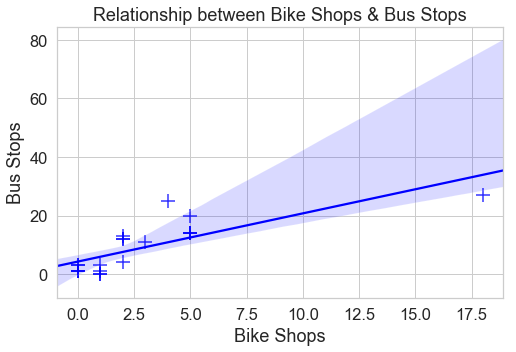

In [216]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

ax = sns.regplot(x='Bike Store Count', y='Bus Stop Count', data=df, color='blue', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Bike Shops', ylabel='Bus Stops')
ax.set_title('Relationship between Bike Shops & Bus Stops')

In [217]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
X = df[['Bike Store Count']]
Y = df['Bus Stop Count']
lm.fit(X,Y)
print('The R-square is: ', lm.score(X, Y))

The R-square is:  0.6091253274650157


In [218]:
# Remove outlier from the data
df_minusyork = df.drop(labels=1,axis=0)

Text(0.5,1,'Relationship between Bike Shops & Bus Stops')

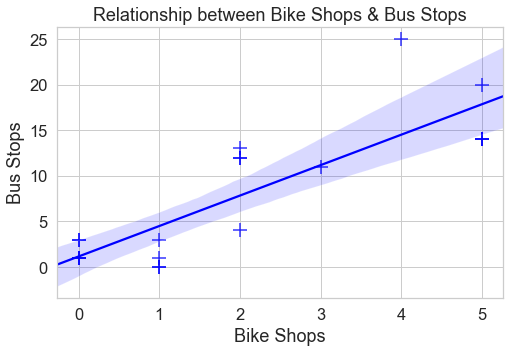

In [219]:
plt.figure(figsize=(8, 5))

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

ax = sns.regplot(x='Bike Store Count', y='Bus Stop Count', data=df_minusyork, color='blue', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Bike Shops', ylabel='Bus Stops')
ax.set_title('Relationship between Bike Shops & Bus Stops')

In [220]:
lm = LinearRegression()
X = df_minusyork[['Bike Store Count']] 
Y = df_minusyork['Bus Stop Count'] 
lm.fit(X,Y)
print('The R-square is: ', lm.score(X, Y))

The R-square is:  0.7094258564419085


###### Use K-means clustering to find groupings

In [221]:
df = df.drop(["Latitude","Longitude"], axis=1)
df.head()

,Town,Population,Bike Store Count,Sports Shop Count,Bus Stop Count
0,Middlesbrough,174700,2,7,13
1,York,152841,18,20,27
2,Harrogate,73576,5,9,14
3,Scarborough,38715,2,4,12
4,Redcar,37073,0,0,1


In [242]:
X = df.values[:,1:]
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 3.06911989, -0.21711172,  0.43859872,  0.49024328,  3.        ],
       [ 2.59054264,  3.86969709,  3.03031845,  2.18491141,  1.75      ],
       [ 0.85512815,  0.54916493,  0.83732483,  0.611291  ,  0.5       ],
       [ 0.09188731, -0.21711172, -0.15949044,  0.36919556,  0.5       ],
       [ 0.05593764, -0.72796282, -0.95694267, -0.9623294 , -0.75      ],
       [-0.21405708,  0.29373938,  1.435414  ,  1.94281596,  0.5       ],
       [-0.30957986,  0.54916493,  0.83732483,  0.611291  ,  0.5       ],
       [-0.33681579, -0.21711172, -0.3588535 , -0.59918623, -0.75      ],
       [-0.36652572, -0.72796282, -0.75757961, -0.72023396, -0.75      ],
       [-0.39006158, -0.47253727, -0.75757961, -1.08337713, -0.75      ],
       [-0.4176697 ,  0.03831383, -0.95694267,  0.24814783, -0.75      ],
       [-0.43321432, -0.47253727, -0.95694267, -0.72023396, -0.75      ],
       [-0.43557886, -0.47253727,  0.43859872, -1.08337713, -0.75      ],
       [-0.46644916, -0.72796282, -0.7

In [250]:
# Cluster using 4 clusters

num_clusters = 4
k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

In [251]:
df["Labels"] = labels
df

,Town,Population,Bike Store Count,Sports Shop Count,Bus Stop Count,Labels
0,Middlesbrough,174700,2,7,13,3
1,York,152841,18,20,27,2
2,Harrogate,73576,5,9,14,1
3,Scarborough,38715,2,4,12,1
4,Redcar,37073,0,0,1,0
5,Thornaby-on-Tees,24741,4,12,25,1
6,Ingleby Barwick,20378,5,9,14,1
7,"Saltburn, Marske and New Marske",19134,2,3,4,0
8,Guisborough,17777,0,1,3,0
9,Ripon,16702,1,1,0,0


In [252]:
df.groupby('Labels').mean()

,Population,Bike Store Count,Sports Shop Count,Bus Stop Count
Labels,,,,
0,16419.090909,0.818182,1.727273,2.545455
1,26030.000000,4.000000,7.142857,15.857143
2,152841.000000,18.000000,20.000000,27.000000
3,174700.000000,2.000000,7.000000,13.000000
